# Experimental Results

In [19]:
# Import libraries.
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Set font properties.
font_path = '../../fonts/Inter/static/Inter-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

# General plotting.
palette = sns.color_palette("colorblind")
std_alpha = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = "../results/"
PLOT_PATH = f"{PATH}plots/"
os.makedirs(PLOT_PATH, exist_ok=True)
NAT_SYN_PATH = f"{PATH}meta-eval/nat_syn_class/"
PROMPT_COMPARE_PATH = f"{PATH}meta-eval/prompt_compare/"

## 1. Prompt Model Comparison

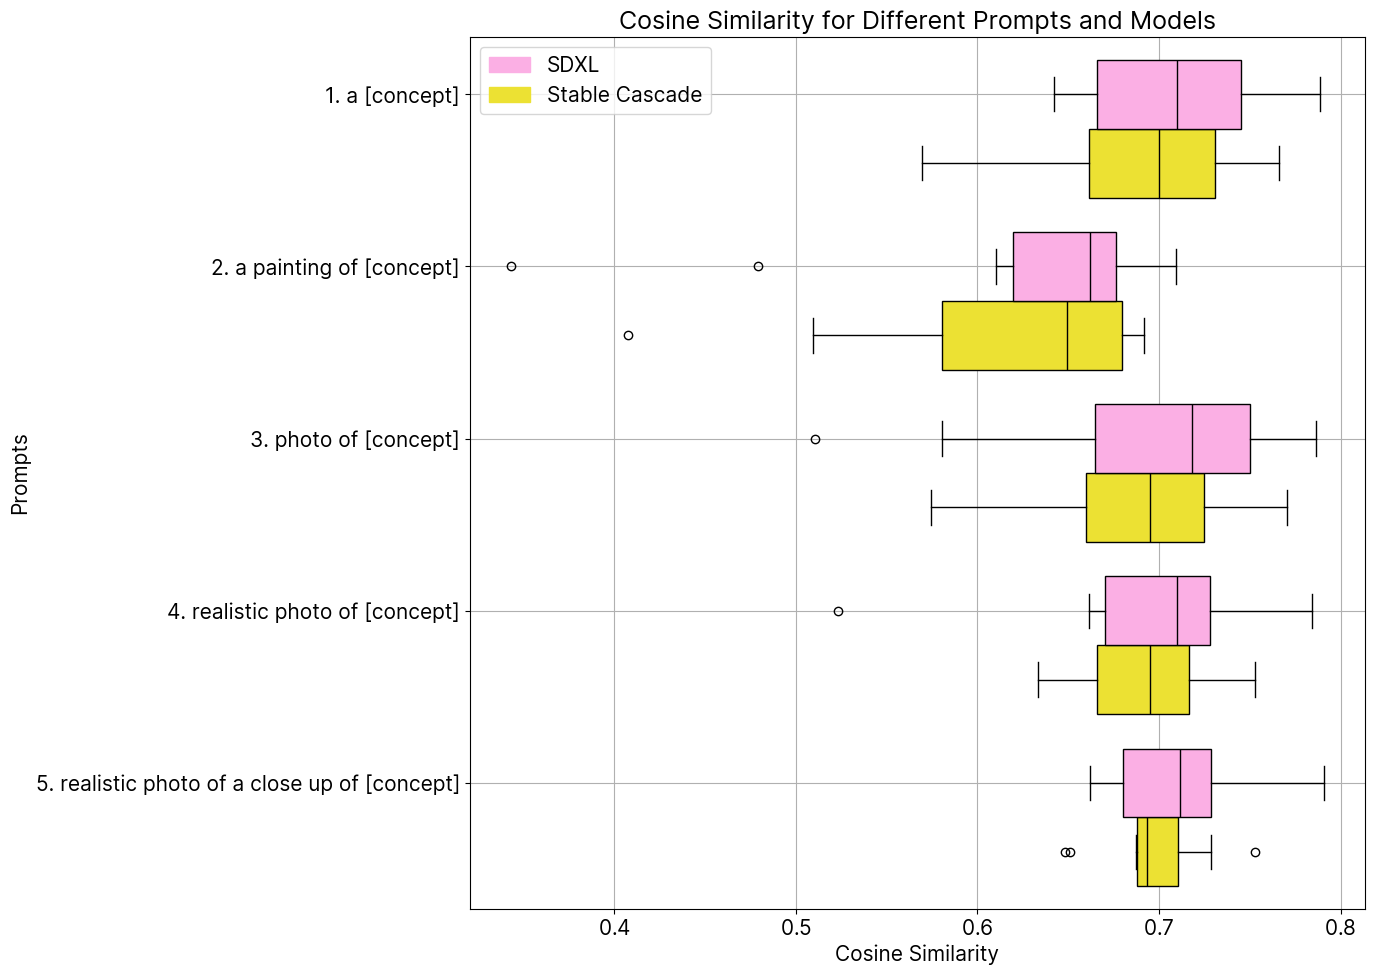

In [23]:
MODEL_NAMES = ["Stable-Cascade", "SDXL1"]
PROMPTS = ["a", "painting_of", "photo", "realistic_photo", "realistic_photo_close"]
PROMPTS.reverse()
PROMPT_NAMES = [
    r"1. a [concept]",
    r"2. a painting of [concept]",
    r"3. photo of [concept]",
    r"4. realistic photo of [concept]",
    r"5. realistic photo of a close up of [concept]"
]
PROMPT_NAMES.reverse()
DISTANCE_PATH = PROMPT_COMPARE_PATH + "distance_tensors/s2n/"

# Load ImageNet classes
CLASSES = ['leatherback turtle', 'beer bottle', 'china cabinet', 'hard disc', 'bulbul', 'english setter', 'cardigan', 'submarine', 'coffee mug', 'switch']

# Create boxplot
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for the boxplots
colors = [palette[8], palette[6]]

# Store data for plotting
data = []

for prompt in PROMPTS:
    for model_name in MODEL_NAMES:
        # Initialize list to store average cosine similarities
        cosine_similarity_avg_list = []

        # Iterate over the classes
        for class_name in CLASSES:
            class_name = class_name.replace(" ", "_")
            tensor_path = os.path.join(DISTANCE_PATH, f"concept_distances_{prompt}_{model_name}_{class_name}.pt")
            concept_distances = torch.load(tensor_path).cpu().detach()

            # Calculate average cosine similarity
            cosine_similarity_avg = torch.mean(concept_distances[0])
            cosine_similarity_avg_list.append(cosine_similarity_avg.item())

        data.append(cosine_similarity_avg_list)

# Plot boxplots
positions = []
width = 0.6  # Width of the boxplots
gap = 0.3  # Gap between different prompts
for i in range(len(PROMPTS)):
    positions.extend([i * (2 * width + gap) + j * width for j in range(len(MODEL_NAMES))])

bp = ax.boxplot(data, vert=False, patch_artist=True, positions=positions, widths=width, medianprops=dict(color='black'))

# Set colors for the boxes
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i % len(MODEL_NAMES)])

# Set y-axis labels
y_ticks = [(i * (2 * width + gap) + width) for i in range(len(PROMPTS))]
ax.set_yticks(y_ticks)
ax.set_yticklabels(PROMPT_NAMES)
ax.set_ylabel('Prompts')
ax.set_xlabel('Cosine Similarity')
ax.set_title('Cosine Similarity for Different Prompts and Models')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
handles.reverse()
labels = ["Stable Cascade", "SDXL"]
labels.reverse()
ax.legend(handles, labels)

plt.grid(True)
plt.tight_layout()
# plt.savefig(PLOT_PATH + f"cs_prompt_model.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"cs_prompt_model.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"cs_prompt_model.svg", bbox_inches='tight')
plt.show()


## 2. Compare Natural and Synthetic Images

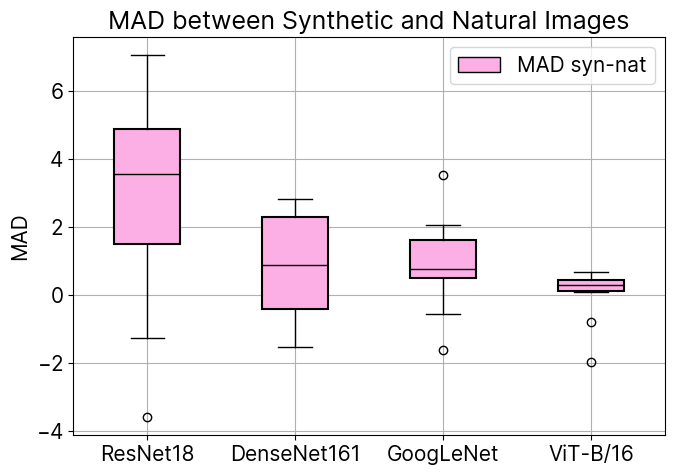

In [52]:
NEURON_IDS = [34, 440, 495, 592, 16, 212, 264, 833, 504, 844]
MODELS = ['resnet18-fc', 'densenet161-fc', 'googlenet-fc', 'vit_b_16-head']
ticks = ['ResNet18', 'DenseNet161', 'GoogLeNet', 'ViT-B/16']

mad_data = [] # [res, dens, goog, vit]

for model in MODELS:
    mad_model = []
    for neuron_id in NEURON_IDS:
        activ_class_syn = torch.load(f"{NAT_SYN_PATH}{model}_neuron-{neuron_id}.pt")[:, neuron_id].cpu().numpy()
        activ_class_nat = torch.load(f"{NAT_SYN_PATH}{model}_natural_neuron-{neuron_id}.pt")[:, neuron_id].cpu().numpy()

        mad_class = activ_class_syn.mean() - activ_class_nat.mean()
        mad_model.append(mad_class)
    
    mad_data.append(mad_model)

# Plotting
plt.figure(figsize=(7, 5))

# Create boxplot
bpl = plt.boxplot(mad_data, patch_artist=True,                  
                  boxprops=dict(facecolor=palette[6], 
                  edgecolor='black', linewidth=1.5),
                  medianprops=dict(color='black'))


# Customize boxplot colors
color = palette[6]
# hatch = '///'
for patch in bpl['boxes']:
    patch.set_facecolor(color)
    # patch.set_hatch(hatch)

# Add labels and title
plt.xticks(np.arange(1, len(MODELS) + 1), ticks)
plt.ylabel('MAD')
plt.title('MAD between Synthetic and Natural Images')

# Add legend
legend_labels = ['MAD syn-nat']
legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='black')]
# legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor=palette[7], hatch=hatch)]
plt.legend(legend_patches, legend_labels, loc='upper right')

plt.grid(True)
plt.tight_layout()
# plt.savefig(PLOT_PATH + f"mad_nat-syn_comparison.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"mad_nat-syn_comparison.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"mad_nat-syn_comparison.svg", bbox_inches='tight')
plt.show()

In [6]:
NEURON_IDS = [34, 440, 495, 592, 16, 212, 264, 833, 504, 844]
CONCEPT_NAMES = ['leatherback turtle', 'beer bottle', 'china cabinet', 'hard disc', 'bulbul', 'english setter', 'cardigan', 'submarine', 'coffee mug', 'switch']
CONCEPT_IDS = ['n01665541', 'n02823428', 'n03018349', 'n03492542', 'n01560419', 'n02100735', 'n02113186', 'n04347754', 'n03063599', 'n04372370']
df_imgnt = pd.read_csv("../assets/ILSVRC2012_val_labels.csv")
MODELS = ['resnet18-fc', 'densenet161-fc', 'googlenet-fc', 'vit_b_16-head']
ticks = ['ResNet18', 'DenseNet161', 'GoogLeNet', 'ViT-B/16']

# Initialize lists to collect mean differences for each model
mean_diffs_nat = {model: [] for model in MODELS}
mean_diffs_syn = {model: [] for model in MODELS}

nat_data = [] # [res_nat, dens_nat, goog_nat, vit_nat]
syn_data = [] # [res_syn, dens_syn, goog_syn, vit_syn]

for model in MODELS:
    model_mean_diffs_nat = []
    model_mean_diffs_syn = []
    for neuron_id, concept_id in zip(NEURON_IDS, CONCEPT_IDS):
        # Filter for images including classes
        df_class = df_imgnt[df_imgnt[concept_id] == 1]
        # Filter for images not including classes
        df_non_class = df_imgnt[df_imgnt[concept_id] == 0]

        A_F_val = torch.load(f"../activations/val_{model}.pt").cpu().numpy()
        activ = A_F_val[:, neuron_id]  # All activations for neuron_id on val dataset
        activ_non_class = activ[df_non_class.index]  # Activations without natural class
        activ_class_nat = activ[df_class.index]  # Activations with natural class
        activ_class_syn = torch.load(f"{NAT_SYN_PATH}{model}_neuron-{neuron_id}.pt")[:, neuron_id].cpu().numpy()

        avg_activation_diff_nat = activ_class_nat.mean() - activ_non_class.mean()
        avg_activation_diff_syn = activ_class_syn.mean() - activ_non_class.mean()

        model_mean_diffs_nat.append(avg_activation_diff_nat)
        model_mean_diffs_syn.append(avg_activation_diff_syn)
    
    nat_data.append(model_mean_diffs_nat)
    syn_data.append(model_mean_diffs_syn)

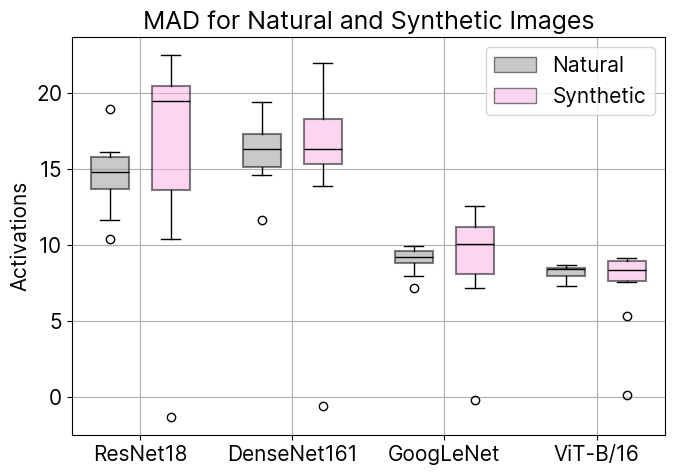

In [46]:
plt.figure(figsize=(7, 5))

# Plot natural data
bpl = plt.boxplot(nat_data, positions=np.array(range(len(nat_data))) * 2.0 - 0.4, patch_artist=True,
                  boxprops=dict(facecolor=palette[7], alpha=0.5, edgecolor='k', linewidth=1.5),
                  medianprops=dict(color='black'))

# Plot synthetic data
bpr = plt.boxplot(syn_data, positions=np.array(range(len(syn_data))) * 2.0 + 0.4, patch_artist=True,
                  boxprops=dict(facecolor=palette[6], alpha=0.5, edgecolor='k', linewidth=1.5),
                  medianprops=dict(color='black'))

# # Create legend
legend_labels = ['Natural', 'Synthetic']
legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.5, edgecolor='black') for color in [palette[7], palette[6]]]
plt.legend(legend_patches, legend_labels, loc='best')

plt.xticks(range(0, len(ticks) * 2, 2), ticks)

plt.ylabel('Activations')
plt.title('MAD for Natural and Synthetic Images')

plt.grid(True)
plt.tight_layout()
# plt.savefig(PLOT_PATH + f"mean_activ_nat-syn_comparison.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"mean_activ_nat-syn_comparison.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"mean_activ_nat-syn_comparison.svg", bbox_inches='tight')
plt.show()


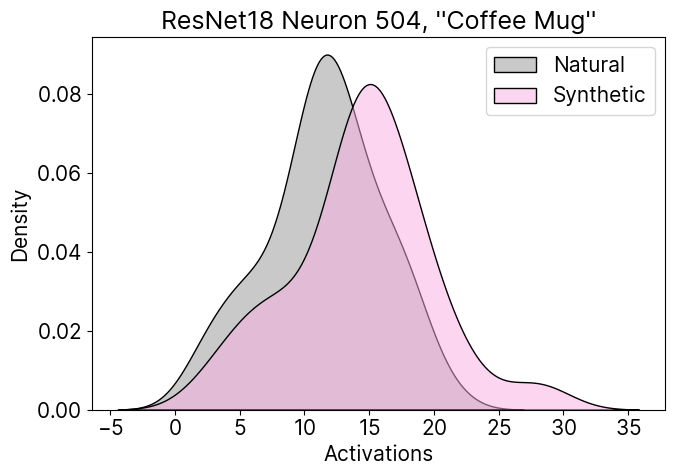

In [47]:
MODEL_NAME = "resnet18-fc"
NEURON = 504  # coffee mug

# Load data
res_nat = torch.load(f"{NAT_SYN_PATH}{MODEL_NAME}_natural_neuron-{NEURON}.pt")[:, NEURON].cpu().numpy()
res_syn = torch.load(f"{NAT_SYN_PATH}{MODEL_NAME}_neuron-{NEURON}.pt")[:, NEURON].cpu().numpy()

# Create DataFrame
res_neuron_df = pd.DataFrame({'Natural': res_nat, 'Synthetic': res_syn})

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

sns.kdeplot(data=res_neuron_df['Natural'], common_norm=True, color=palette[7], fill=True, alpha=0.5, edgecolor='black', label='Natural', ax=ax)
sns.kdeplot(data=res_neuron_df['Synthetic'], common_norm=True, color=palette[6], fill=True, alpha=0.5, edgecolor='black', label='Synthetic', ax=ax)

plt.xlabel('Activations')
plt.title("ResNet18 Neuron 504, ''Coffee Mug''")
plt.tight_layout()
plt.legend()

# Save plots
# plt.savefig(PLOT_PATH + f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.svg", bbox_inches='tight')
plt.show()


## 3. Psi Comparison ResNet18 Layers

In [3]:
MODEL_NAMES = ["resnet18-layer1", "resnet18-layer2", "resnet18-layer3", "resnet18-layer4", "resnet18-fc"]
METHODS = ["INVERT", "CLIP-Dissect", "MILAN", "FALCON-original", "FALCON"]
COLORS = ['#7B6E8A', '#6A947C', '#7D94A5', '#C89B72', '#FEC795']
MARKERS = ['o', 's', 'd', '^', 'v']
x_labels = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Output Layer']
x = np.arange(len(x_labels))

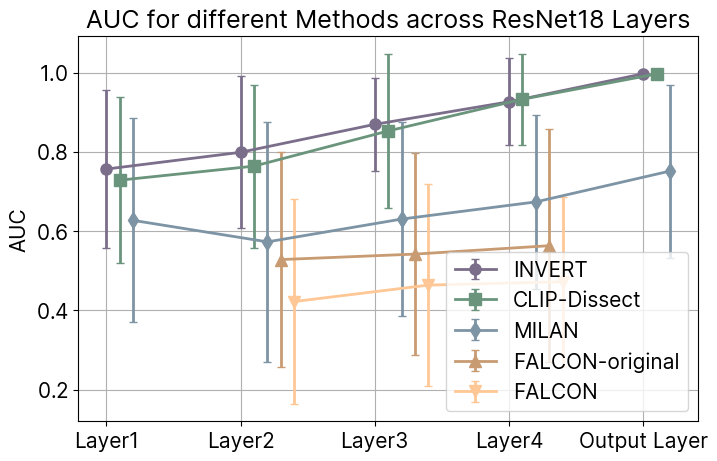

In [91]:
# Initialize dictionaries to hold means and stds for each method
means = {method: [] for method in METHODS}
stds = {method: [] for method in METHODS}

# Load data and calculate means and stds
for model_name in MODEL_NAMES:
    for method in METHODS:
        try:
            df = pd.read_csv(f"{PATH}evaluation_{method}_{model_name}.csv")
            means[method].append(df['auc'].mean())
            stds[method].append(df['auc'].std())
        except FileNotFoundError:
            # Append NaN if the file does not exist for a particular method and layer
            means[method].append(np.nan)
            stds[method].append(np.nan)

# Create a line plot
plt.figure(figsize=(8, 5))

# Offset value to avoid overlap
offset = 0.1

# Plot error bars for each method with offset
for i, method in enumerate(METHODS):
    plt.errorbar([xi + i*offset for xi in x], means[method], yerr=stds[method], marker=MARKERS[i], 
                 linestyle='-', color=COLORS[i], capsize=3, label=method, linewidth=2, markersize=8)
    
# Customize the plot
# plt.xlabel('Layers')
plt.ylabel('AUC')
plt.title('AUC for different Methods across ResNet18 Layers')
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.svg", bbox_inches='tight')
plt.show()

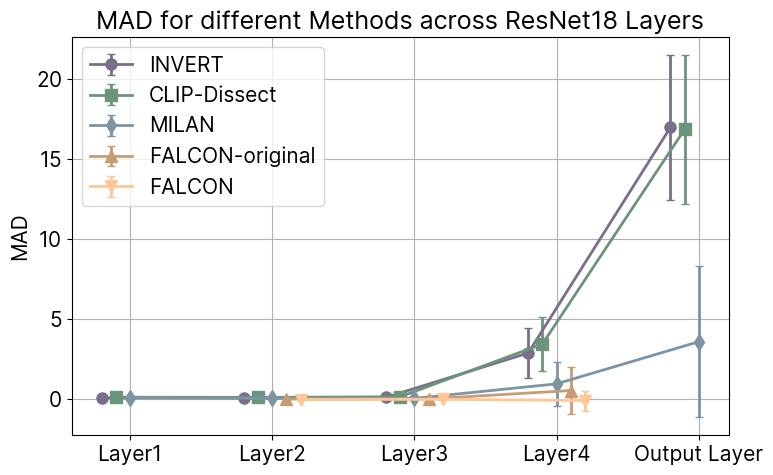

In [93]:
# Initialize dictionaries to hold means and stds for each method
means = {method: [] for method in METHODS}
stds = {method: [] for method in METHODS}

# Load data and calculate means and stds
for model_name in MODEL_NAMES:
    for method in METHODS:
        try:
            df = pd.read_csv(f"{PATH}evaluation_{method}_{model_name}.csv")
            means[method].append(df['avg. activation diff'].mean())
            stds[method].append(df['avg. activation diff'].std())
        except FileNotFoundError:
            # Append NaN if the file does not exist for a particular method and layer
            means[method].append(np.nan)
            stds[method].append(np.nan)

# Create a line plot
plt.figure(figsize=(8, 5))

# Offset value to avoid overlap
offset = 0.1

# Plot error bars for each method with offset
for i, method in enumerate(METHODS):
    plt.errorbar([xi + i*offset for xi in x], means[method], yerr=stds[method], marker=MARKERS[i], 
                 linestyle='-', color=COLORS[i], capsize=3, label=method, linewidth=2, markersize=8)

# Customize the plot
plt.ylabel('MAD')
plt.title('MAD for different Methods across ResNet18 Layers')
plt.xticks([xi + offset*(len(METHODS)-1)/2 for xi in x], x_labels)  # Center the xticks
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot if needed
# plt.savefig(PLOT_PATH + f"MAD_resnet18_layers.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"MAD_resnet18_layers.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH + f"MAD_resnet18_layers.svg", bbox_inches='tight')

# Show the plot
plt.show()

## 4. Qualitative Analysis of individual Neurons

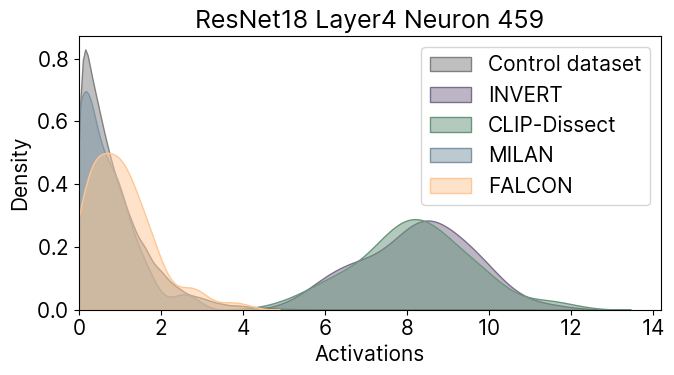

In [12]:
ACTIVATION_PATH = "../activations/"
MODEL_NAME = "resnet18-layer4"
METHODS = ["INVERT", "CLIP-Dissect", "MILAN", "FALCON"]
COLORS = ['#7B6E8A', '#6A947C', '#7D94A5', '#FEC795']
NEURON_IDS = [459, 155, 260]
neuron_id = NEURON_IDS[0]

A_F_val = torch.load(f"{ACTIVATION_PATH}/val_{MODEL_NAME}.pt").cpu().numpy()

df_activations = pd.DataFrame()

for method in METHODS:
    if method == "FALCON":
        activ_class = torch.load(f"{ACTIVATION_PATH}method_eval/FALCON_{MODEL_NAME}_neuron-{neuron_id}_filter.pt").cpu().numpy()
    else:
        activ_class = torch.load(f"{ACTIVATION_PATH}method_eval/{method}_{MODEL_NAME}_neuron-{neuron_id}.pt").cpu().numpy()
    
    # Adding method's activations to the DataFrame
    df_method = pd.DataFrame({method: activ_class[:, neuron_id].tolist()})
    df_activations = pd.concat([df_activations, df_method], axis=1)

plt.figure(figsize=(7, 4))

# Plotting control dataset
sns.kdeplot(data=A_F_val[:, neuron_id], common_norm=True, color='grey', fill=True, label="Control dataset", alpha=0.5)

# Plotting activations for each method
for method, color in zip(METHODS, COLORS):
    sns.kdeplot(data=df_activations[method], common_norm=True, color=color, fill=True, alpha=0.5, label=method)


plt.xlim(0)
plt.xlabel('Activations')
plt.title(f"ResNet18 Layer4 Neuron {neuron_id}")
plt.legend()
plt.tight_layout()
# plt.savefig(PLOT_PATH+f"activ_distribution_{MODEL_NAME}_neuron-{neuron_id}.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"activ_distribution_{MODEL_NAME}_neuron-{neuron_id}.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"activ_distribution_{MODEL_NAME}_neuron-{neuron_id}.svg", bbox_inches='tight')
plt.show()

## 5. Concept Broadness

/tmp/ipykernel_13941/2350067671.py:46: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x='hyper', y='cosine', hue='label', data=combined_df, palette=palette, legend=True)


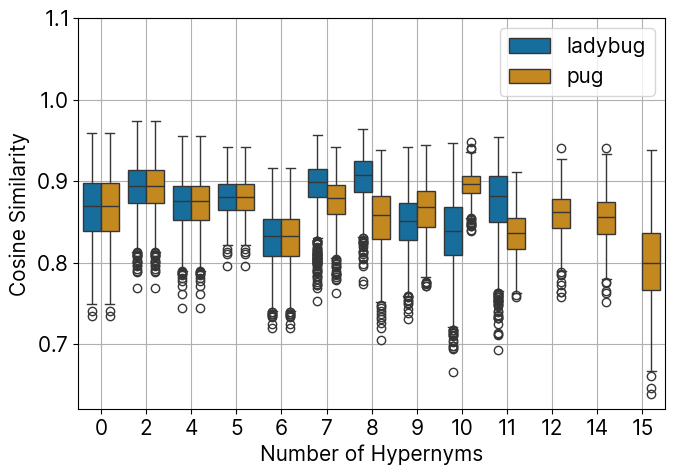

In [20]:
dict_data1 = {}
dict_data2 = {}
labels = ['ladybug','pug']

file = "broadness_values.npz"
data1 = np.load(f"{PATH}meta-eval/broadness/ladybug/{file}")
dict_data1['cosine'] = data1['all_x']
dict_data1['hyper'] = data1['all_y']
data2 = np.load(f"{PATH}meta-eval/broadness/pug/{file}")
dict_data2['cosine'] = data2['all_x']
dict_data2['hyper'] = data2['all_y']


# construct pandas array.
df1 = pd.DataFrame.from_dict(dict_data1)
df1['label'] = [labels[0]] * len(data1['all_x'])
df2 = pd.DataFrame.from_dict(dict_data2)
df2['label'] = [labels[1]] * len(data2['all_x'])
combined_df = pd.concat([df1,df2], ignore_index=True)

plt.figure(figsize=(7, 5))
sns.boxplot(x='hyper', y='cosine', hue='label', data=combined_df, palette=palette, legend=True)

# Set labels and title
plt.ylabel("Cosine Similarity")
plt.xlabel("Number of Hypernyms")
plt.ylim(0.62,1.1)
plt.legend()

plt.grid(True)
plt.tight_layout()

# plt.savefig(PLOT_PATH+f"broadness_pug-ladybug.png", dpi=600, bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"broadness_pug-ladybug.svg", dpi=600, bbox_inches='tight')
plt.show()